In [1]:
import sys
sys.path.insert(1, '../analysis')
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import uproot
import pickle
import Master
import vector

In [2]:
root_file = "/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root"

events = uproot.open(root_file)["pduneana/beamana"]

In [5]:
events.keys()

['Run',
 'SubRun',
 'EventID',
 'totalEvents',
 'beamEvents',
 'beamNum',
 'pdgCode',
 'pandoraTag',
 'reco_daughter_PFP_emScore_collection',
 'reco_daughter_PFP_trackScore_collection',
 'CNNScore_collection',
 'reco_daughter_allShower_startX',
 'reco_daughter_allShower_startY',
 'reco_daughter_allShower_startZ',
 'reco_daughter_allShower_dirX',
 'reco_daughter_allShower_dirY',
 'reco_daughter_allShower_dirZ',
 'reco_daughter_allShower_coneAngle',
 'reco_daughter_allShower_length',
 'reco_daughter_PFP_nHits_collection',
 'reco_daughter_allShower_energy',
 'hitRadial',
 'hitLongitudinal',
 'reco_daughter_allShower_spacePointX',
 'reco_daughter_allShower_spacePointY',
 'reco_daughter_allShower_spacePointZ',
 'reco_beam_startX',
 'reco_beam_startY',
 'reco_beam_startZ',
 'reco_beam_endX',
 'reco_beam_endY',
 'reco_beam_endZ',
 'reco_daughter_PFP_true_byHits_startX',
 'reco_daughter_PFP_true_byHits_startY',
 'reco_daughter_PFP_true_byHits_startZ',
 'reco_daughter_PFP_true_byHits_endX',
 'r

In [ ]:
filtered = events.arrays(["reco_daughter_PFP_nHits_collection", "reco_daughter_allShower_dirX", "reco_daughter_allShower_dirY", "reco_daughter_allShower_dirZ"], "(beamNum != -999) & ((beamNum == reco_PFP_ID) | (beamNum == reco_PFP_Mother)) & (reco_daughter_PFP_nHits_collection > 50)")

In [2]:
class Cut():
    def __init__(self, events):
        self.filter = None
        pass

class BeamCut(Cut):
    def __init__(self, events):
        has_beam = events["beamNum"].array() != -999
        beam_particle = events["beamNum"].array() == events["reco_PFP_ID"].array()
        beam_daughters = events["beamNum"].array() == events["reco_PFP_Mother"].array()
        self.filter = np.logical_and(has_beam, np.logical_or(beam_particle, beam_daughters))
        return

class HitsCut(Cut):
    def __init__(self, events):
        self.filter = events["reco_daughter_PFP_nHits_collection"].array() > 50
        return

# Over-engineering...
# def knownParticles():
#     class knownParticlesClass():
#         def __init__(self):
#             self.particles_list = {
#                 'photon':22
#             }
        
#         def __call__(self) -> dict:
#             return self.particles_list
        
#         @property
#         def inverted(self) -> dict:
#             return {self.particles_list[particle] : particle for particle in self.particles_list.keys()}

#     return knownParticlesClass()

# Global list of known particles
def knownParticles(invert = False):
    particle_list = {
        'photon':22
    }
    if not invert:
        return particle_list
    else:
        return {particle_list[particle] : particle for particle in particle_list.keys()}

# Helper function to lookup particle with errors on problems
def lookupParticle(particle) -> tuple[str, int]:
    if isinstance(particle, str):
        try:
            particle_pdg = knownParticles()[particle]
        except:
            raise ValueError(f"Unknown particle: {particle}")
    elif isinstance(particle, int):
        try:
            particle_pdg = particle
            # Inverts the particle by creating a list of keys, then indexing by the position of the pdg code
            particle = knownParticles(invert=True)[particle_pdg]
        except:
            raise ValueError(f"Unknown particle pdg: {particle}")
    else:
        raise TypeError(f"Cannot determine particle from argument: {particle}")
    return particle, particle_pdg


def plotStackedHistSimple(data, pdgs, label, particle = 'photon', title = '', **kwargs):
    # Uses global list of known particles
    particle, cut_pdg = lookupParticle(particle)

    # Set figure size
    plt.figure(figsize=(12,8))

    # Plot the data
    plt.hist(data, bins=200, label="other", **kwargs)
    plt.hist(data[pdgs == cut_pdg], bins=200, label=particle, **kwargs)

    # Make it look (pretty)
    plt.xlabel(label)
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.show()
    return

def plotParameterDistribution(data, pdgs, title_text, key, particle = 22):
    particle, particle_pdg = lookupParticle(particle)
    # Plot parameter for valid/known results (value != -999)
    valid_plot_title = title_text
    # If pandoraTag is used, we show the efficiency of a cut on pandoraTag = 11
    if key == "pandoraTag":
        pred_frac = 1 - (ak.num(data[np.logical_and(data != -999, pdgs == particle_pdg)], axis=0) - ak.num(data[np.logical_and(data == 11, pdgs == particle_pdg)], axis=0))/ak.num(data[np.logical_and(data != -999, pdgs == particle_pdg)], axis=0)
        valid_plot_title += "\n{:.1f}% {}s assigned as 11".format(pred_frac*100, particle)
    plotStackedHistSimple(data[data != -999], pdgs[data != -999], key, particle=particle, title=valid_plot_title)

    # Plot parameter including unknown results, and give the proportion
    unknown_total = (ak.num(data, axis=0) - ak.num(data[data != -999], axis=0))/ak.num(data, axis=0)
    unknown_particle = (ak.num(data[pdgs == particle_pdg], axis=0) - ak.num(data[np.logical_and(data != -999, pdgs == particle_pdg)], axis=0))/ak.num(data[pdgs == particle_pdg], axis=0)
    full_plot_title = title_text + " with unknowns (-999) included\n{:.1f}% {}s unknown, {:.1f}% total unknown".format(100*unknown_particle, particle, 100*unknown_total)
    plotStackedHistSimple(data, pdgs, key, particle=particle, title=full_plot_title)

    return


def plotMultiBeamDistribution(data_dict, key, unknowns = False, normalise = 'all',  particle = 22, colours_all = None, colours_particle = None, log = False, **plt_kwargs):
    # Get the particle to look at
    particle, particle_pdg = lookupParticle(particle)


    # Get desired colours for histograms
    if isinstance(colours_all, dict):
        def allColourKwarg(energy_index):
            return {'color':colours_all[energy_index]}
    else:
        def allColourKwarg(energy_index):
            return {}
    
    if isinstance(colours_particle, dict):
        def particleColourKwarg(energy_index):
            return {'color':colours_particle[energy_index]}
    else:
        def particleColourKwarg(energy_index):
            return {}


    # Set figure size
    plt.figure(figsize=(12,8))

    for energy in data_dict.keys():
        # Get data from dictionary
        eng_data = ak.flatten(data_dict[energy].recoParticles.GetValues(key))
        eng_pdgs = ak.flatten(data_dict[energy].trueParticlesBT.pdg)


        # Filter out unkown particles if desired
        if not unknowns:
            eng_pdgs = eng_pdgs[eng_data != -999]
            eng_data = eng_data[eng_data != -999]


        # Set the normalisation
        # Maybe want to put normalisation before filtering out unknowns?
        if normalise == 'all':
            num = ak.num(eng_data, axis=0)
            normalise_text = "\nNormalised to equal PFO numbers"
        elif isinstance(normalise, int):
            num = ak.num(eng_data[eng_pdgs == normalise], axis=0)
            normalise_text = f"\nNormalised to equal {particle} numbers"
        elif normalise == 'particle' or normalise == particle:
            num = ak.num(eng_data[eng_pdgs == particle_pdg], axis=0)
            normalise_text = f"\nNormalised to equal {particle} numbers"
        else:
            num = 1
            normalise_text = ""


        # Set the bins to be equal to 4 if we're looking at just the valid pandora tags(11 or 13)
        bins = 4 if key == "pandoraTag" and not unknowns else 200


        # Plot all data
        plt.hist(
            eng_data,
            bins=bins, histtype='step',
            label="{}GeV all".format(energy),
            weights=np.full_like(eng_data.to_numpy(), 1/num, dtype=np.float32),
            **allColourKwarg(energy),
            **plt_kwargs
        )

        hist_label = hist_label = "{}GeV photons".format(energy)

        if key == "pandoraTag":
            pred_frac = 1 - (
                      ak.num(eng_data[eng_pdgs == particle_pdg], axis=0)
                    - ak.num(eng_data[np.logical_and(eng_data == 11, eng_pdgs == particle_pdg)], axis=0)
                ) / ak.num(eng_data[ eng_pdgs == particle_pdg], axis=0)
            hist_label += ", {:.1f}%=11".format(100*pred_frac)

        plt.hist(
            eng_data[eng_pdgs == particle_pdg],
            bins=bins, histtype='step', label=hist_label,
            weights=np.full_like(eng_data[eng_pdgs == particle_pdg].to_numpy(), 1/num, dtype=np.float32),
            **particleColourKwarg(energy),
            **plt_kwargs
        )
    
    plt.xlabel(key)
    plt.ylabel("Count")
    if log:
        plt.yscale('log')
    plt.title(f"{key} for " + ", ".join([ str(e) for e in list(data_dict.keys())[:-1] ]) + f", and {list(data_dict.keys())[-1]} GeV beams{normalise_text}")
    plt.legend()
    plt.show()
    return


def rocCurve(datas, pdgs, labels=None, particle=22, cut_high = True, cut_func=None, norm=False, ax = None, include_unknown=False, **kwargs):
    """
    TODO: Properly add text!
    Optional cut function must take inputs of the form: (data, mask, cut_value)
    """

    particle, particle_pdg = lookupParticle(particle)

    if not isinstance(datas, list):
        datas = [datas]
    # If pdgs is not a list, we use the same pdg for each bit of data, else lookup the corresponding value
    lookup_pdg = isinstance(pdgs, list)

    show_plot = False
    if not ax:
        show_plot = True
        # Set figure size
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot()

    for ind, data in enumerate(datas):
        true_sig_mask = pdgs[ind] == particle_pdg if lookup_pdg else pdgs == particle_pdg
        bkg_mask = pdgs[ind] != particle_pdg if lookup_pdg else pdgs != particle_pdg
        known_mask = data != -999

        # Automatically remove unknowns from the signal, since we assume this get discarded
        sig_mask = np.logical_and(true_sig_mask, known_mask)

        if not include_unknown:
            bkg_mask = np.logical_and(bkg_mask, known_mask)
            
        cut_vals = np.linspace(min(data[known_mask]), max(data[known_mask]), num=101)
        
        efficiency = np.zeros_like(cut_vals[1:])
        background_frac = np.zeros_like(cut_vals[1:])

        for i, cut in enumerate(cut_vals[1:]):
            # Abusing the fact we can sum True as 1 and False as 0
            if cut_func:
                efficiency[i] = sum(cut_func(data, sig_mask, cut))
                background_frac[i] = sum(cut_func(data, bkg_mask, cut))
            elif cut_high:
                efficiency[i] = sum(data[sig_mask] < cut)
                background_frac[i] = sum(data[bkg_mask] < cut)
            else:
                efficiency[i] = sum(data[sig_mask] > cut)
                background_frac[i] = sum(data[bkg_mask] > cut)
        
        if norm:
            efficiency = efficiency/ak.num(data[true_sig_mask], axis=0) # Handled separately to account for unkown particles, if relevant
            background_frac = background_frac/ak.num(data[bkg_mask], axis=0)
        best_cut = bestROCResult(efficiency, background_frac, cut_vals[1:], norm=norm)
        best_cut_ind = np.where(cut_vals[1:] == best_cut)
        # np.array outputs an array, so result is also an array, which means we also have to add the extra [0]
        print("Best cut found to be {:.3f} with fpr: {:.3f}, eff: {:.3f}.".format(best_cut, background_frac[best_cut_ind][0], efficiency[best_cut_ind][0]))

        if isinstance(labels, list):
            labels = {'label': labels[ind]}
        elif isinstance(labels, str):
            labels = {'label': labels}
        else:
            labels = {}

        # Plot the data
        ax.plot(background_frac, efficiency, **labels, marker='x', **kwargs)

    # Make it look (pretty)
    if norm:
        ax.set_xlabel("Background cut fraction")
        ax.set_ylabel("Efficiency")
    else:
        ax.set_xlabel("Background remaining")
        ax.set_ylabel("Signal remaining")

    if labels:
        ax.legend()
    ax.set_xlim(0)
    ax.set_ylim(0)

    if show_plot:
        plt.show()

    return

def bestROCResult(efficiencies, fprates, cuts, sd_eval=False, norm=False, eval_func=None):
    if eval_func is None:
        if norm:
            def eval_func(eff, fpr):
                return np.sqrt((1-eff)**2 + fpr**2)
        else:
            if sd_eval:
                def eval_func(eff, fpr):
                    return np.sqrt(fpr)/eff
            else:
                def eval_func(eff, fpr):
                    return fpr/eff
    
    best_val = eval_func(efficiencies[-1], fprates[-1])
    best_cut = cuts[-1]

    for i, efficiency in enumerate(efficiencies[:-1]):
        val = eval_func(efficiency, fprates[i])
        if val < best_val:
            best_val = val
            best_cut = cuts[i]
    return best_cut


In [3]:
# # Expected execution time: 4 minutes
# beam = BeamCut(events)
# print("Beam done")
# hits = HitsCut(events)
# print("Hits done")
# quality_cut = np.logical_and(beam.filter, hits.filter)
# with open("/scratch/wx21978/pi0/filters/6GeV_beam_00-quality.pkl", 'wb') as f:
#     pickle.dump(quality_cut, f)

with open("/scratch/wx21978/pi0/filters/6GeV_beam_00-quality.pkl", 'rb') as f:
    quality_cut = pickle.load(f)

In [4]:
# total_cuts = quality_cut

# directions = ak.zip({
#     "x" : events["reco_daughter_allShower_startX"].array()[total_cuts],
#     "y" : events["reco_daughter_allShower_startY"].array()[total_cuts],
#     "z" : events["reco_daughter_allShower_startZ"].array()[total_cuts]
# })
# energies = events["reco_daughter_allShower_energy"].array()[total_cuts]

# mom = vector.prod(energies, directions)
# mom = ak.where(directions.x == -999, {"x": -999,"y": -999,"z": -999}, mom)
# mom = ak.where(energies < 0, {"x": -999,"y": -999,"z": -999}, mom)

# props = {
#     "direction" :   directions,
#     "energy"    :   energies,
#     "momentum"  :   mom,
#     "start_pos" :   ak.zip({"x" : events["reco_daughter_allShower_startX"].array()[total_cuts],
#                             "y" : events["reco_daughter_allShower_startY"].array()[total_cuts],
#                             "z" : events["reco_daughter_allShower_startZ"].array()[total_cuts]}),
#     "pdg"       :   events["reco_daughter_PFP_true_byHits_pdg"].array()[total_cuts]
# }

# mom.delete()
# energies.delete()
# directions.delete()

# with open("/scratch/wx21978/pi0/filters/6GeV_beam_00-props.pkl", 'wb') as f:
#     pickle.dump(props, f)

with open("/scratch/wx21978/pi0/filters/6GeV_beam_00-props.pkl", 'rb') as f:
    props = pickle.load(f)

In [2]:
def rotate_in_plane(x, y, cos_rot, negative=True, normalised=False):
    """
    Rotate the vector x, y in the plane by the angle defined by cos_rot.
    """

    if not normalised:
        length = np.sqrt(x**2 + y**2)
        x = x/length
        y = y/length
    else:
        length = 1

    cos_init = x
    
    sin_init = y
    # sin(a) = sqrt(1-cos^2(a))
    sin_rot = np.sqrt(1 - cos_rot**2)

    direction = 1 - 2 * int(negative)

    # cos(a+b) = cos(a)cos(b)-sin(a)sin(b)
    x_new = (cos_init * cos_rot - direction * sin_init * sin_rot) * length

    # sin(a+b) = sin(a)cos(b)+cos(a)sin(b)
    y_new = (sin_init * cos_rot + direction * cos_init * sin_rot) * length
    
    # If we have an inverted array, we can set the value to be exactly true
    x_new = ak.where(np.isclose(cos_init, -1 * direction * cos_rot, atol=1e-15), length, x_new)
    y_new = ak.where(np.isclose(cos_init, -1 * direction * cos_rot, atol=1e-15), 0, y_new)
    
    return x_new, y_new

def get_normalised_values(dir1, dir2, start1, start2):
    """
    Unpack the akward arrays, then normalise dir1 and start1 such that
    start2 = (0,0,0) and dir2 = (0,0,1)
    Does have to worry about events which are very close to an axis
    """
    # Unpack values from inputs
    vx_1, vy_1, vz_1 = ak.unzip(dir1)
    vx_2, vy_2, vz_2 = ak.unzip(dir2)
    x_1, y_1, z_1 = ak.unzip(start1)
    x_2, y_2, z_2 = ak.unzip(start2)

    # Move the origin to start2 = (0,0,0)
    #   and dir2 = (0,0,1)
    x_1 = x_1 - x_2
    y_1 = y_1 - y_2
    z_1 = z_1 - z_2
    
    # First rotation in aroud z-axis:
    #   z = cos(theta)
    #   x = sin(theta) cos(phi)
    # So cos(phi) = x/sqrt(1-z^2)
    cos_rot_1 = vx_2/np.sqrt(1-vz_2**2)
    vx_1, vy_1 = rotate_in_plane(vx_1, vy_1, cos_rot_1)

    # Now rotate about y:
    # From permutations, new RH axis is z, x
    # Rotation angle is just cos(theta) = vz_2
    vz_1, vx_1 = rotate_in_plane(vz_1, vx_1, vz_2)

    # Debug, after process, should have dir2 = (0,0,1):
    # vx_2, vy_2 = rotate_in_plane(vx_2, vy_2, cos_rot_1)
    # vz_2, vx_2 = rotate_in_plane(vz_2, vx_2, vz_2)
    # print(f"DEBUG: dir2 is ({vx_2}, {vy_2}, {vz_2})")
    return vx_1, vy_1, vz_1, x_1, y_1, z_1

def normalise_vectors(x_1, y_1, z_1, vx_1, vy_1, vz_1, pos_x, pos_y, pos_z, cos_rot_z, cos_rot_y):
    """
    normalise dir1 and start1 such that
    start1 -> start1 - pos
    dir1 -> rotate by cos_rot_z around z axis then cos_rot_y around y axis
    """
    # Move the origin to start2 = (0,0,0)
    #   and dir2 = (0,0,1)
    x_1 = x_1 - pos_x
    y_1 = y_1 - pos_y
    z_1 = z_1 - pos_z
    
    vx_1, vy_1 = rotate_in_plane(vx_1, vy_1, cos_rot_z)

    vz_1, vx_1 = rotate_in_plane(vz_1, vx_1, cos_rot_y)

    return vx_1, vy_1, vz_1, x_1, y_1, z_1

def closest_approach(dir1, dir2, start1, start2):
    """
    Takes the directions and start positions of two vectors.
    Returns the shortest distance between the two points
    """

    # Unpack values from inputs
    vx_1, vy_1, vz_1 = ak.unzip(dir1)
    vx_2, vy_2, vz_2 = ak.unzip(dir2)
    x_1, y_1, z_1 = ak.unzip(start1)
    x_2, y_2, z_2 = ak.unzip(start2)

    # First rotation in aroud z-axis:
    #   z = cos(theta)
    #   x = sin(theta) cos(phi)
    # So cos(phi) = x/sqrt(1-z^2)
    cos_rot_z = vx_2/np.sqrt(1-vz_2**2)
    # Then rotate about y:
    # From permutations, new RH axis is z, x
    # Rotation angle is just cos(theta) = vz_2
    vx, vy, vz, x, y, z = normalise_vectors(x_1, y_1, z_1, vx_1, vy_1, vz_1, x_2, y_2, z_2, cos_rot_z, vz_2)

    # x_1 - x_2 + lambda_1 v_1 - lambda_2 v_2 = d/sin(theta) v_1 x v_2

    # Separation between the lines
    d = (x*vy - y*vx)/np.sqrt(vx**2 + vy**2)

    # Closest point in line 1 is at x_1 + lambda_1*v_1
    lambda_1 = -(x*vx + y*vy)/(vx**2 + vy**2)

    # Closest point in line 1 is at x_2 + lambda_2*v_2
    lambda_2 = z + lambda_1*vz

    # DEBUG: these should be true
    # print("Check sums:")
    # print(f"{x + lambda_1*vx} = {vy*d/np.sqrt(1-vz**2)}")
    # print(f"{y + lambda_1*vy} = {-vx*d/np.sqrt(1-vz**2)}")

    # Nearest approach points p_1 and p_2
    p_1_x = x + lambda_1 * vx_1
    p_1_y = y + lambda_1 * vy_1
    p_1_z = z + lambda_1 * vz_1
    p_2_x = x + lambda_2 * vx_2
    p_2_y = y + lambda_2 * vy_2
    p_2_z = z + lambda_2 * vz_2

    return d, ak.zip({'x':(p_1_x + p_2_x)/2, 'y':(p_1_y + p_2_y)/2, 'z':(p_1_z + p_2_z)/2})

def closest_approach(dir1, dir2, start1, start2):
    """
    Takes the directions and start positions of two vectors.
    Returns the shortest distance between the two points
    """
    # x_1 - x_2 + lambda_1 v_1 - lambda_2 v_2 = d/sin(theta) v_1 x v_2
    cross = vector.cross(dir1, dir2)
    rel_start = vector.sub(start1, start2)

    # Separation between the lines
    d = vector.dot(rel_start, cross)/vector.magnitude(cross)

    off_start = vector.sub(d * vector.normalize(cross), rel_start)

    # Get the lambda values from components
    lambda_1 = d*(vector.cross( off_start, dir2)).x / (vector.magnitude(cross) * cross.x)

    # Closest point in line 1 is at x_1 + lambda_1*v_1
    lambda_1 = -(x*vx + y*vy)/(vx**2 + vy**2)

    # Closest point in line 1 is at x_2 + lambda_2*v_2
    lambda_2 = z + lambda_1*vz

    # DEBUG: these should be true
    # print("Check sums:")
    # print(f"{x + lambda_1*vx} = {vy*d/np.sqrt(1-vz**2)}")
    # print(f"{y + lambda_1*vy} = {-vx*d/np.sqrt(1-vz**2)}")

    # Nearest approach points p_1 and p_2
    p_1_x = x + lambda_1 * vx_1
    p_1_y = y + lambda_1 * vy_1
    p_1_z = z + lambda_1 * vz_1
    p_2_x = x + lambda_2 * vx_2
    p_2_y = y + lambda_2 * vy_2
    p_2_z = z + lambda_2 * vz_2

    return d, ak.zip({'x':(p_1_x + p_2_x)/2, 'y':(p_1_y + p_2_y)/2, 'z':(p_1_z + p_2_z)/2})
    

num_tests = 100
theta_1 = np.pi * np.random.uniform(low=0., high=2., size=num_tests)
phi_1 = np.pi * np.random.uniform(low=0., high=2., size=num_tests)
test_dir_1 = ak.zip({
    "x": ak.Array(np.sin(theta_1) * np.cos(phi_1)),
    "y": ak.Array(np.sin(theta_1) * np.sin(phi_1)),
    "z": ak.Array(np.cos(theta_1))
})
test_start_1 = ak.zip({
    "x": ak.Array(np.random.uniform(low=-100., high=100., size=num_tests)),
    "y": ak.Array(np.random.uniform(low=-100., high=100., size=num_tests)),
    "z": ak.Array(np.random.uniform(low=-100., high=100., size=num_tests))
})

theta_2 = np.pi * np.random.uniform(low=0., high=2., size=num_tests)
phi_2 = np.pi * np.random.uniform(low=0., high=2., size=num_tests)
test_dir_2 = ak.zip({
    "x": ak.Array(np.sin(theta_2) * np.cos(phi_2)),
    "y": ak.Array(np.sin(theta_2) * np.sin(phi_2)),
    "z": ak.Array(np.cos(theta_2))
})
test_start_2 = ak.zip({
    "x": ak.Array(np.random.uniform(low=-100., high=100., size=num_tests)),
    "y": ak.Array(np.random.uniform(low=-100., high=100., size=num_tests)),
    "z": ak.Array(np.random.uniform(low=-100., high=100., size=num_tests))
})
distance, joint_vertex = closest_approach(test_dir_1, test_dir_2, test_start_1, test_start_2)

print(distance)
# good_mask = np.isclose(d_1, -d_2)
# bad_mask = np.logical_not(good_mask)

# print(d_1[bad_mask])
# print(d_2[bad_mask])
# print(theta_1[bad_mask]/np.pi)
# print(phi_1[bad_mask]/np.pi)
# print(theta_2[bad_mask]/np.pi)
# print(phi_2[bad_mask]/np.pi)

# print(f"Good: max {np.max(np.abs(theta_1[good_mask]/np.pi-theta_2[good_mask]/np.pi))}, min {np.min(np.abs(theta_1[good_mask]/np.pi-theta_2[good_mask]/np.pi))}. Bad: max {np.max(np.abs(theta_1[bad_mask]/np.pi-theta_2[bad_mask]/np.pi))}, min {np.min(np.abs(theta_1[bad_mask]/np.pi-theta_2[bad_mask]/np.pi))}.")
# print(f"Good: max {np.max(np.abs(phi_1[good_mask]/np.pi-phi_2[good_mask]/np.pi))}, min {np.min(np.abs(phi_1[good_mask]/np.pi-phi_2[good_mask]/np.pi))}. Bad: max {np.max(np.abs(phi_1[bad_mask]/np.pi-phi_2[bad_mask]/np.pi))}, min {np.min(np.abs(phi_1[bad_mask]/np.pi-phi_2[bad_mask]/np.pi))}.")

# position = np.arange(num_tests)
# plt.figure(figsize=(20,4))
# plt.scatter(position[good_mask], theta_1[good_mask], color='r', marker='o', label="theta_1 (Good)")
# plt.scatter(position[bad_mask], theta_1[bad_mask], color='r', marker='x', label = "theta_1 (Bad)")
# plt.scatter(position[good_mask], theta_2[good_mask], color='k', marker='o', label="theta_2")
# plt.scatter(position[bad_mask], theta_2[bad_mask], color='k', marker='x')
# plt.scatter(position[good_mask], phi_1[good_mask], color='g', marker='o', label="phi_1")
# plt.scatter(position[bad_mask], phi_1[bad_mask], color='g', marker='x')
# plt.scatter(position[good_mask], phi_2[good_mask], color='b', marker='o', label="phi_2")
# plt.scatter(position[bad_mask], phi_2[bad_mask], color='b', marker='x')
# plt.legend()
# plt.show()

Check sums:
[1.69, -89.8, -63.4, -80.3, 32.9, 55.3, ... -19.5, -31.5, 44.2, 106, 41.8, 5.19] = [1.69, -89.8, -63.4, -80.3, 32.9, 55.3, ... -19.5, -31.5, 44.2, 106, 41.8, 5.19]
[-29.1, 75.7, -20.9, 159, -95.8, -11.1, ... 15.3, 43.6, -62.9, -30.2, -11.4, -34.6] = [29.1, -75.7, 20.9, -159, 95.8, 11.1, -1.5, ... -15.3, -43.6, 62.9, 30.2, 11.4, 34.6]
[-29.1, -118, -66.7, -178, 101, 56.4, 1.52, ... 24.8, -53.9, -76.8, 110, -43.3, 35]


In [6]:
# This cell looks at the VALUES of a given parameter.
param ='pandoraTag'
print(events.recoParticles.GetValues(param))
print(np.unique(ak.flatten(events.recoParticles.GetValues(param)).to_numpy(), return_counts=True))
print(len(np.unique(ak.flatten(events.recoParticles.GetValues(param)).to_numpy())))

[[13, 13, 13, 13, 13, 11, 13, 13, 13, 13], ... [11, 13, 11, 11, 13, 13, -999], []]
(array([-999,   11,   13], dtype=int32), array([ 11379,  55915, 109395]))
3


In [7]:
# This cell looks at the NUMBER of entries for a given parameter.
param='pandoraTag'
depths = ak.num(events.trueParticlesBT.GetValues(param), axis=1)
print(depths)
print(np.unique(depths, return_counts=True))
print(len(np.unique(depths)))

[10, 0, 2, 0, 7, 10, 4, 1, 0, 3, 9, 3, 0, ... 5, 0, 1, 0, 15, 0, 4, 0, 0, 9, 0, 7, 0]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30]), array([14316,  1090,  1621,  2312,  2687,  2751,  2813,  2835,  2553,
        2131,  1667,  1221,   868,   593,   403,   233,   152,    89,
          58,    45,    20,    14,     9,     9,     2,     3,     2,
           3,     1]))
29


[      -321       -211        -13        -11         11         13
         22        211        321       2212       3112       3222
 1000010020 1000010030 1000010040 1000020030 1000020040 1000030060
 1000100210 1000170380 1000170390]


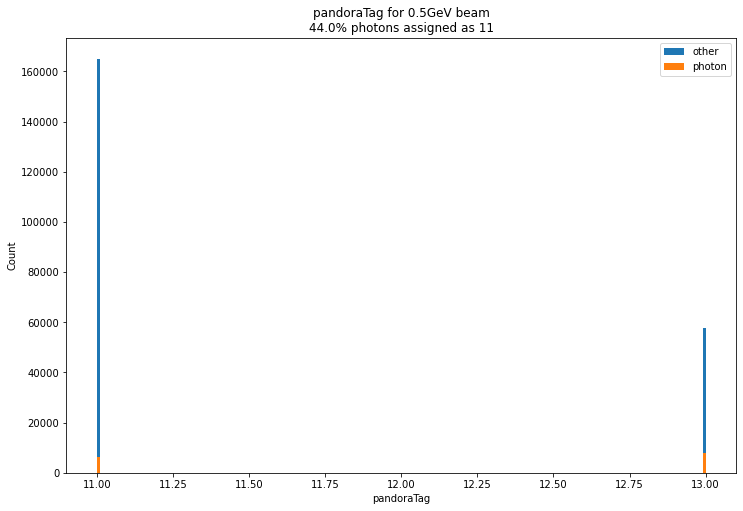

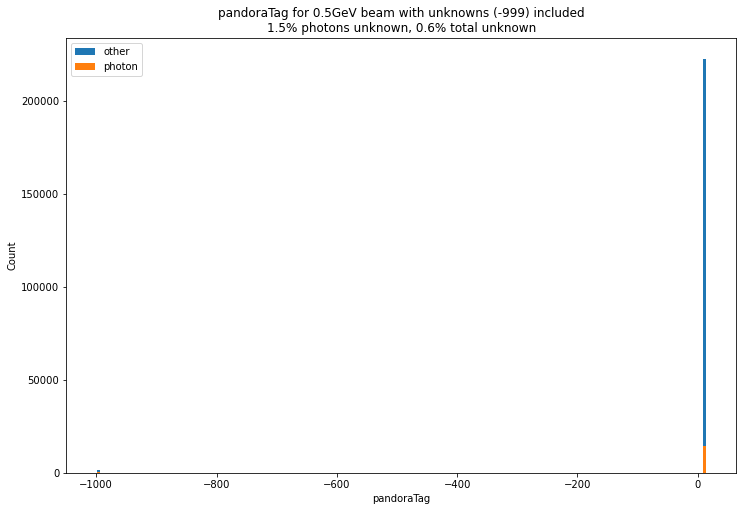

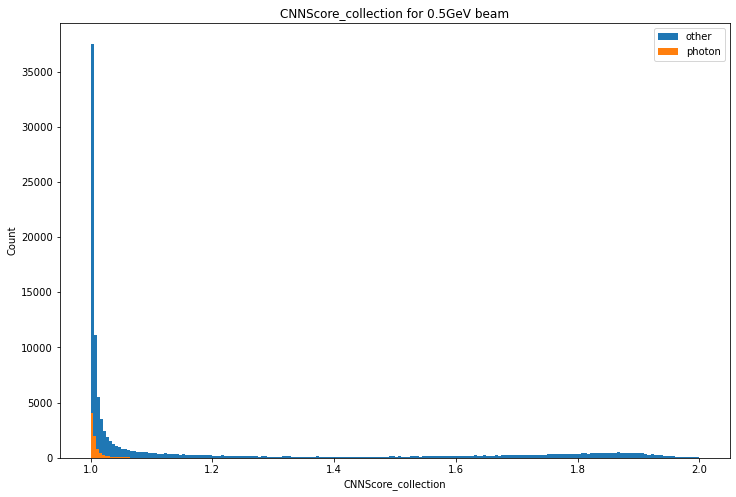

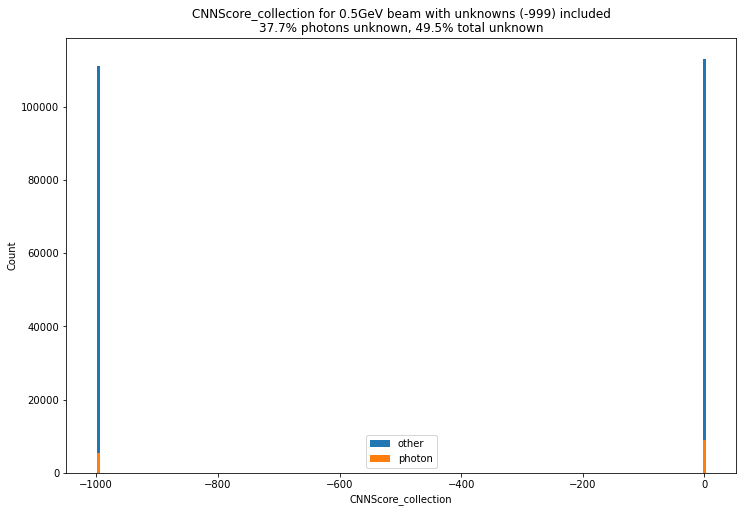

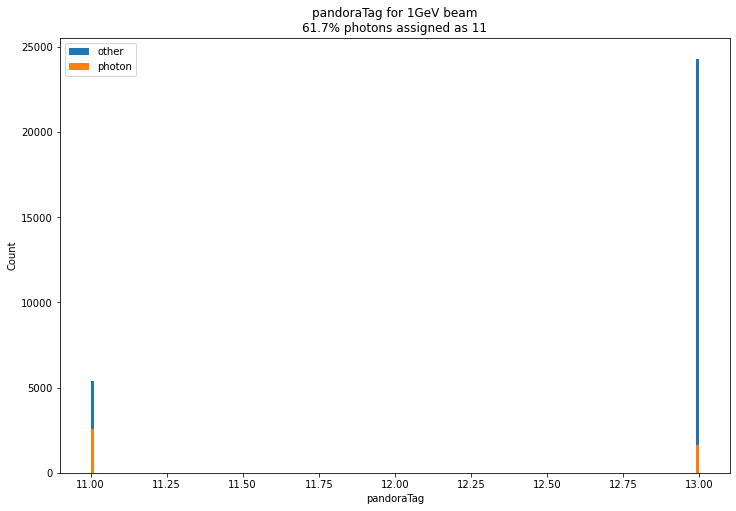

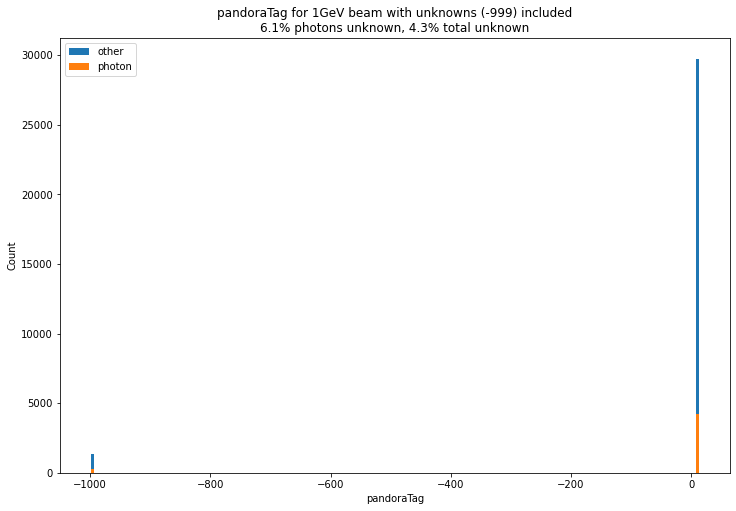

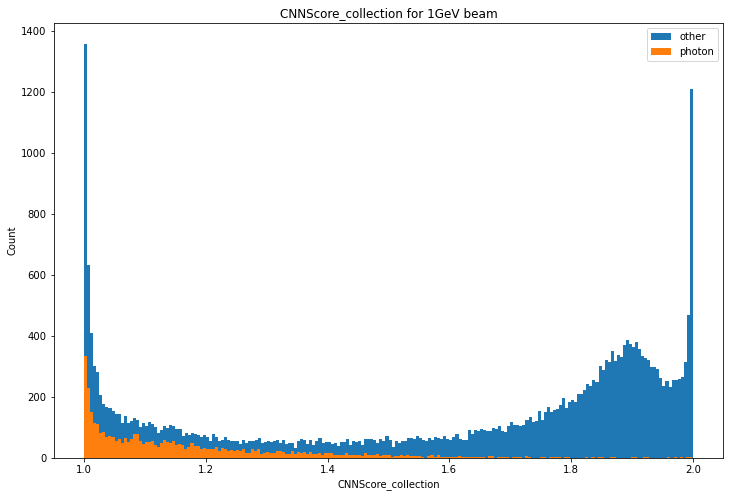

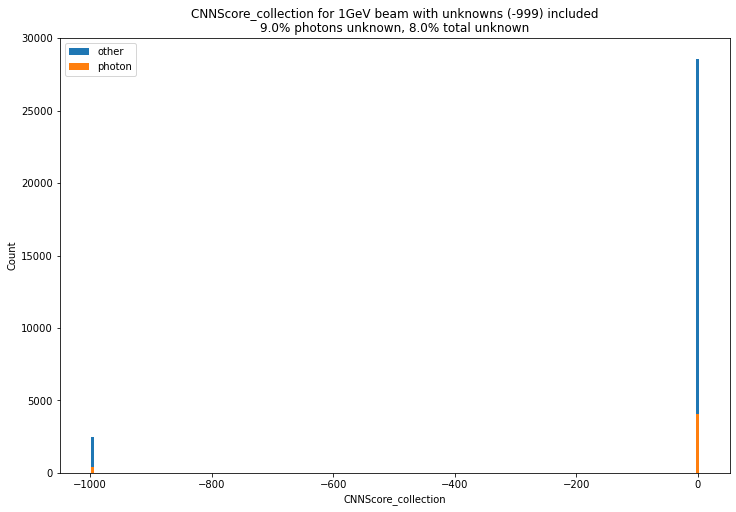

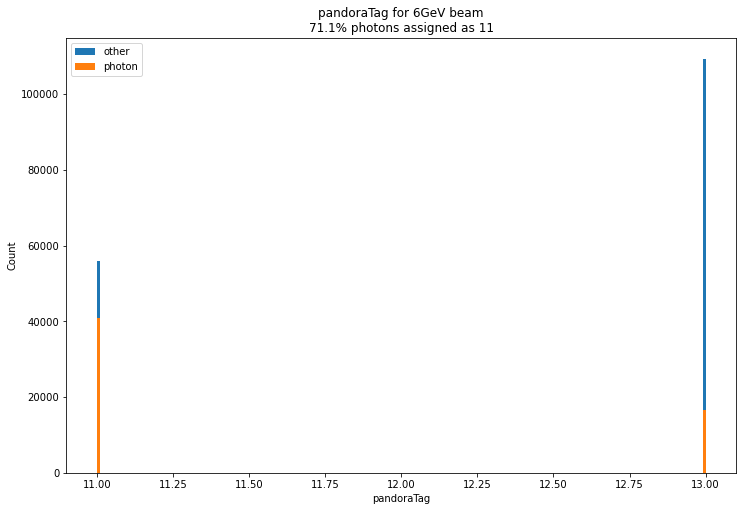

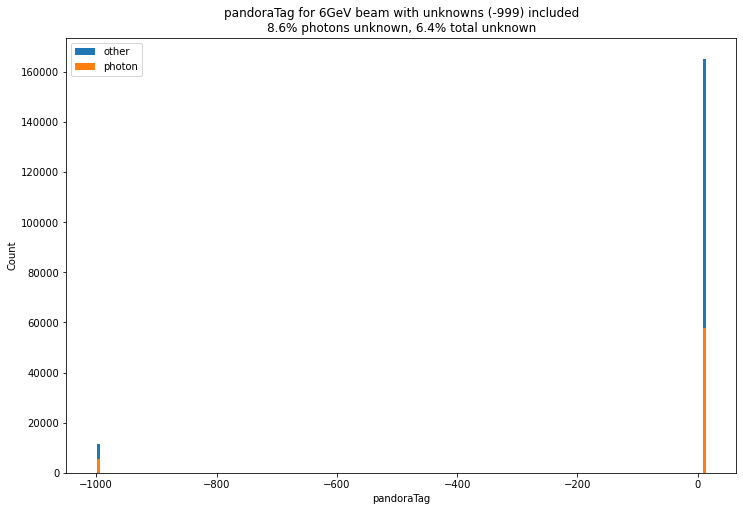

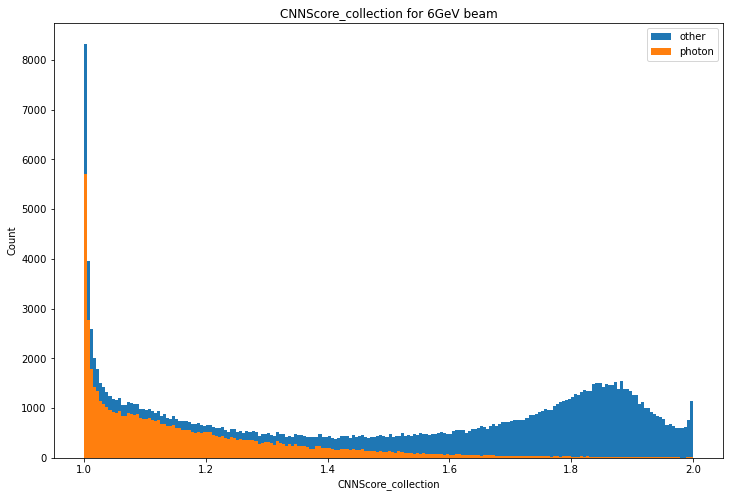

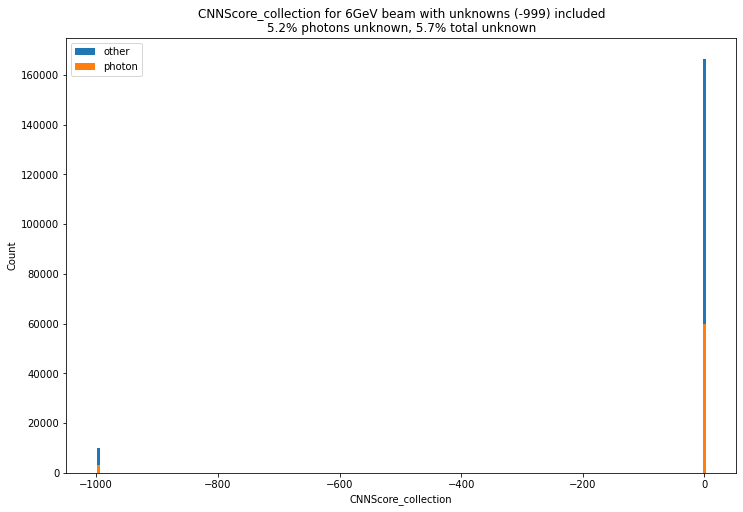

In [15]:
pdgs = ak.flatten(events.trueParticlesBT.pdg)
print(np.unique(pdgs.to_numpy()))

params_to_use = ["pandoraTag", "CNNScore_collection"]

for energy in beamData.keys():
    evts = beamData[energy]
    pdgs = ak.flatten(evts.trueParticlesBT.pdg)
    for key in params_to_use:
        plotParameterDistribution(ak.flatten(evts.recoParticles.GetValues(key)), pdgs, f"{key} for {energy}GeV beam", key)

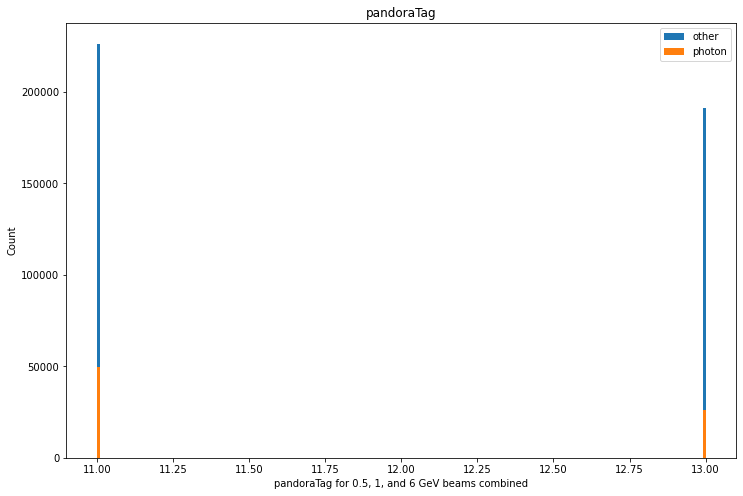

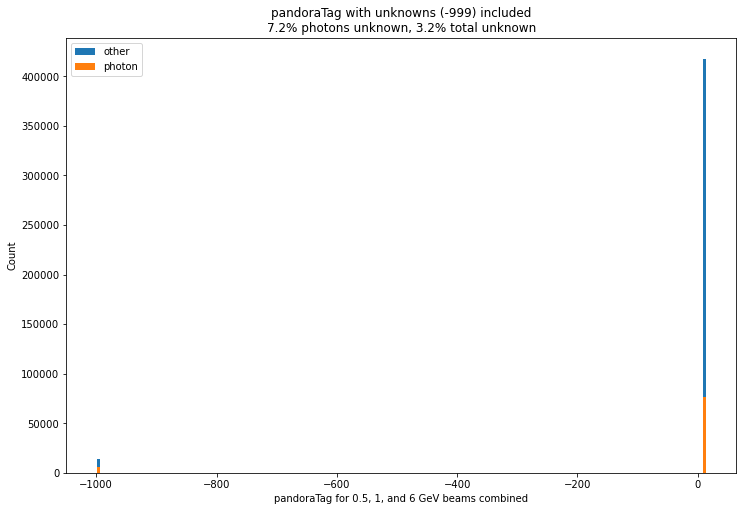

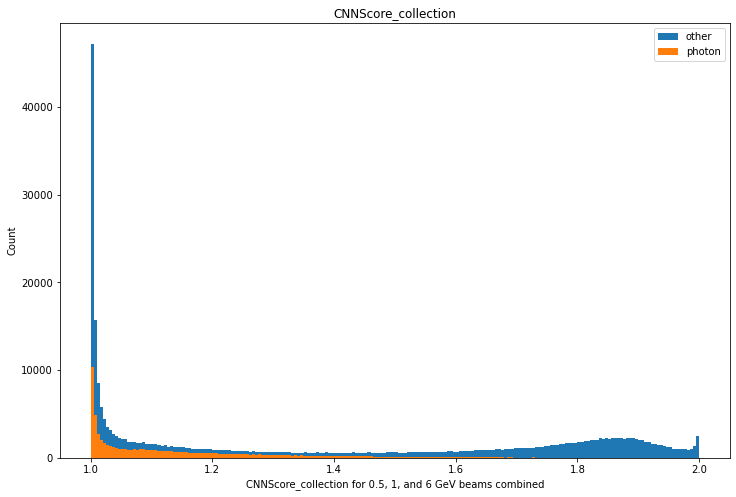

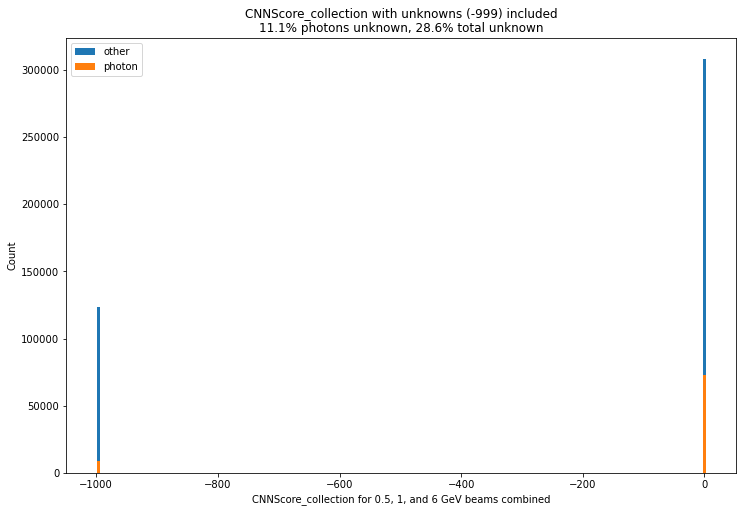

In [16]:
for key in params_to_use:
    sum_data = ak.concatenate([ak.flatten(evts.recoParticles.GetValues(key)) for evts in beamData.values()])
    sum_pdgs = ak.concatenate([ak.flatten(evts.trueParticlesBT.pdg) for evts in beamData.values()])

    plotParameterDistribution(sum_data, sum_pdgs, key, f"{key} for 0.5, 1, and 6 GeV beams combined")

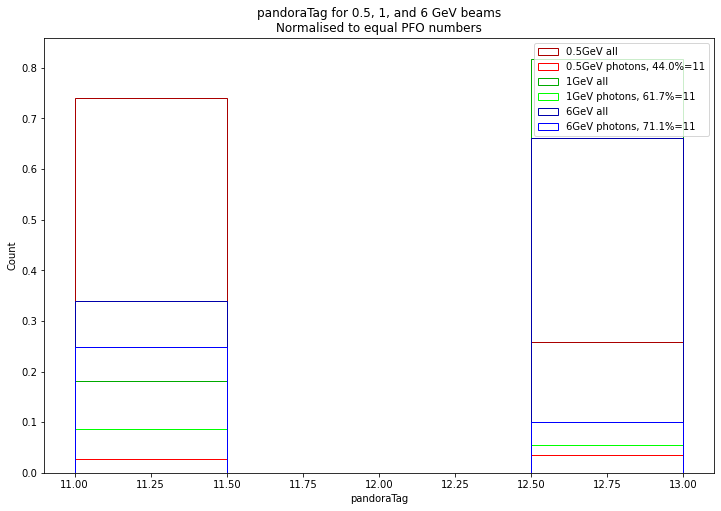

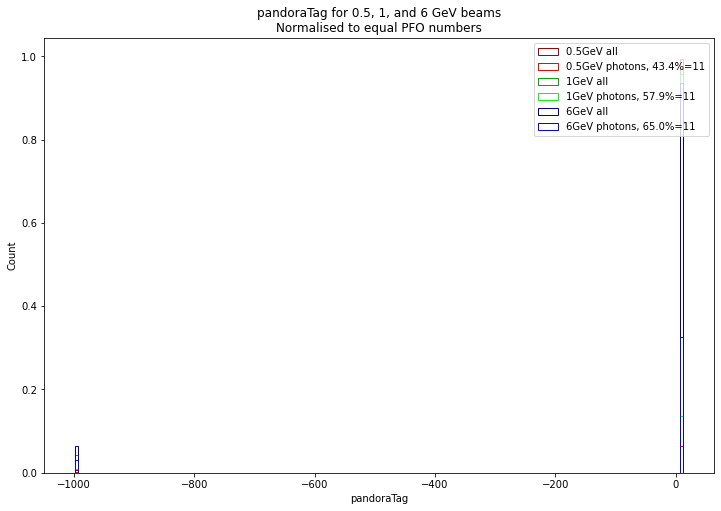

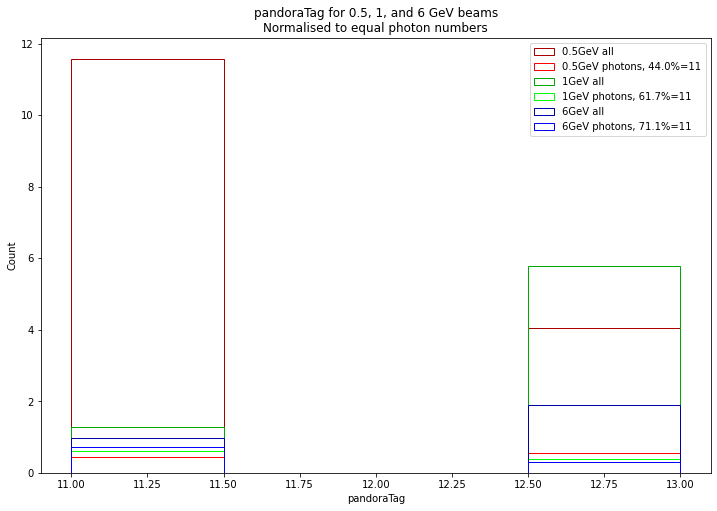

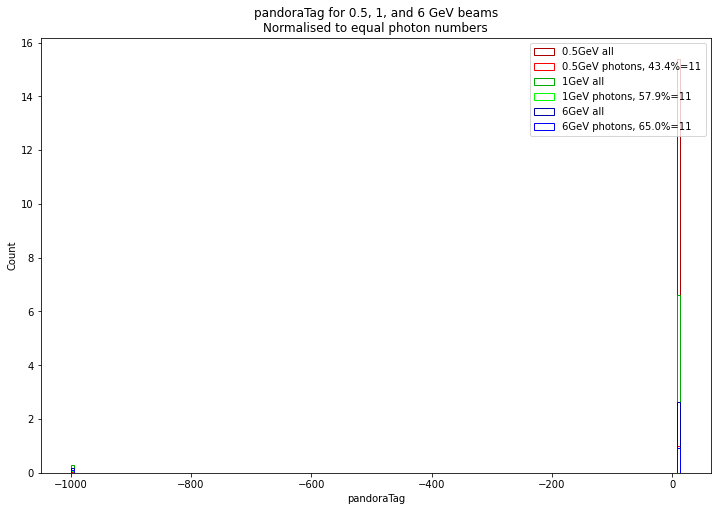

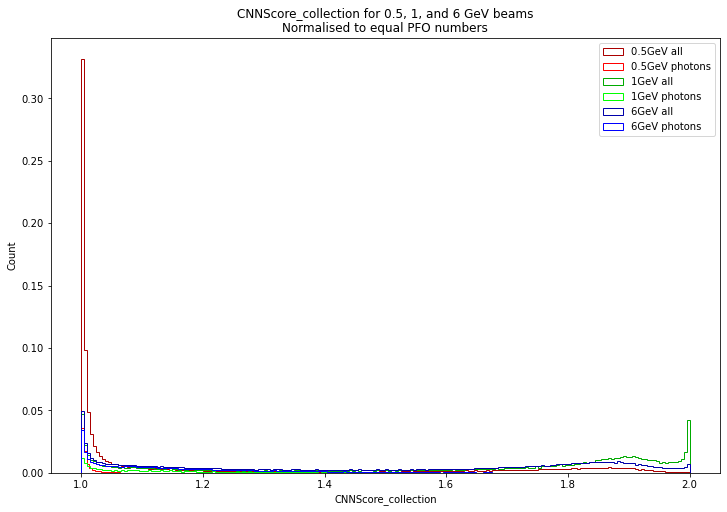

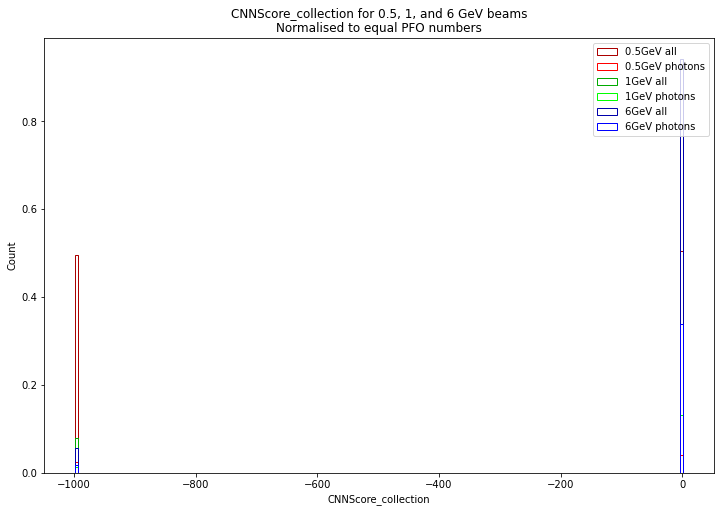

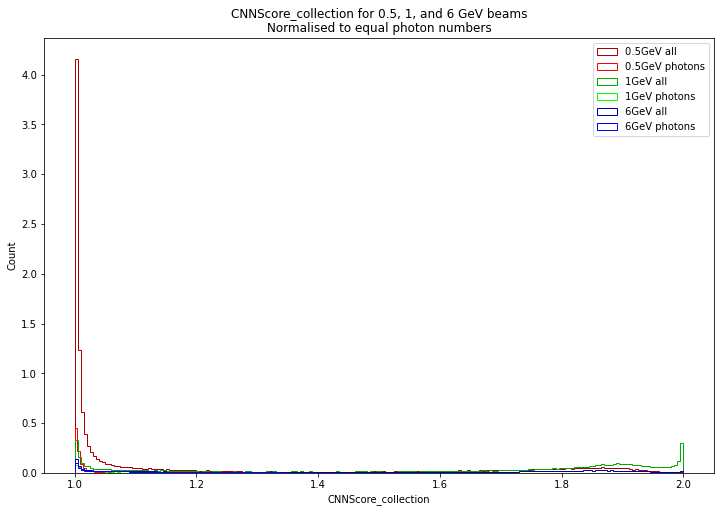

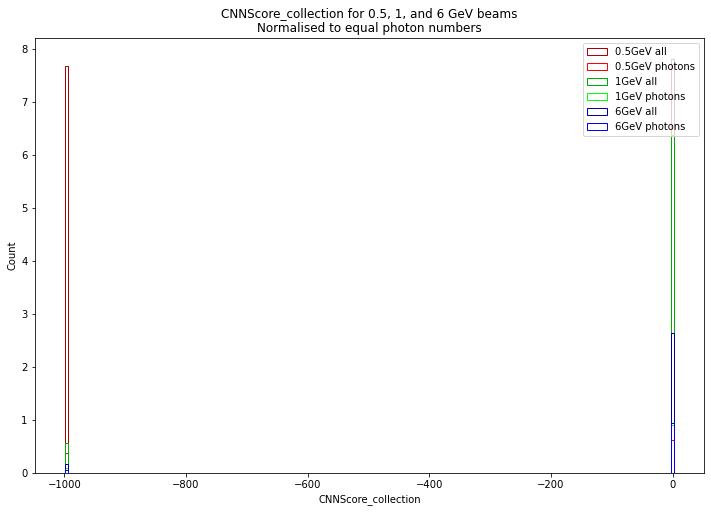

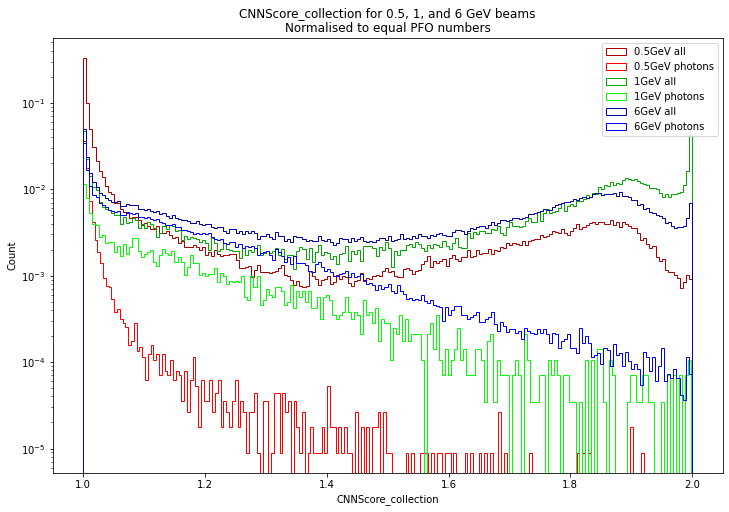

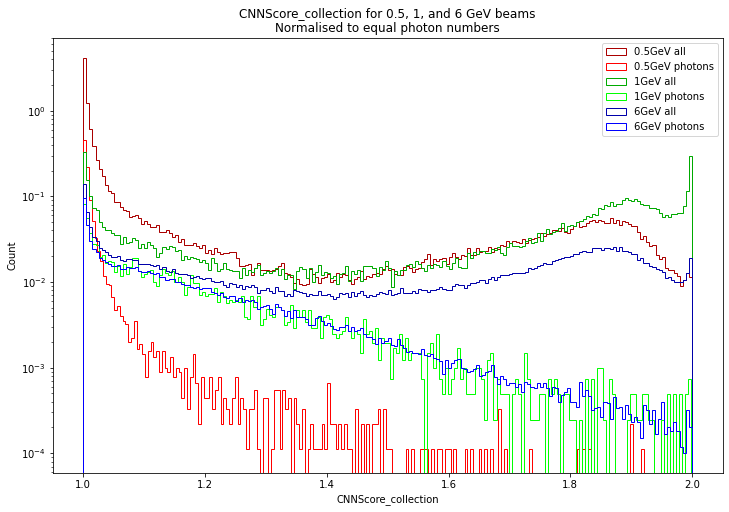

In [21]:
colour_scheme_photons = {
    0.5:"#ff0000",
    1:  "#00ff00",
    6:  "#0000ff",
}
colour_scheme_all = {
    0.5:"#aa0000",
    1:  "#00aa00",
    6:  "#0000aa",
}
for key in params_to_use:
    plotMultiBeamDistribution(beamData, key, unknowns = False, normalise = 'all',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = False)
    plotMultiBeamDistribution(beamData, key, unknowns = True,  normalise = 'all',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = False)
    plotMultiBeamDistribution(beamData, key, unknowns = False, normalise = 'photon',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = False)
    plotMultiBeamDistribution(beamData, key, unknowns = True,  normalise = 'photon',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = False)
    if key == "CNNScore_collection":
        plotMultiBeamDistribution(beamData, key, unknowns = False, normalise = 'all',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = True)
        plotMultiBeamDistribution(beamData, key, unknowns = False, normalise = 'photon',  particle = 22, colours_all = colour_scheme_all, colours_particle = colour_scheme_photons, log = True)

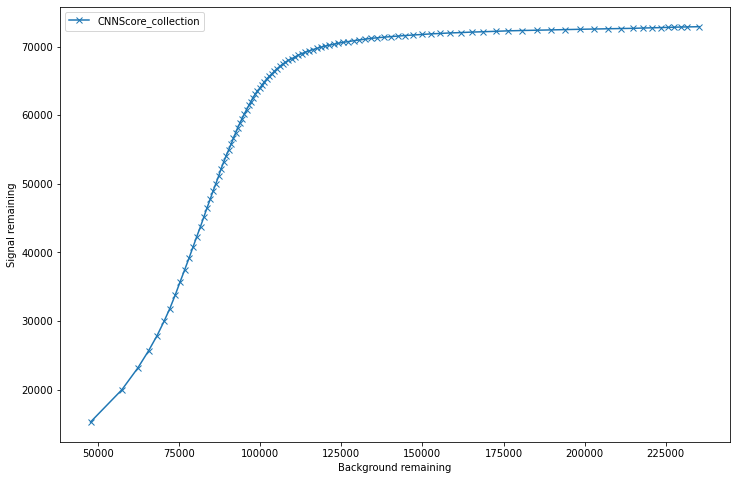

In [21]:
rocCurve(
    ak.concatenate([ak.flatten(evts.recoParticles.GetValues("CNNScore_collection")) for evts in beamData.values()]),
    ak.concatenate([ak.flatten(evts.trueParticlesBT.pdg) for evts in beamData.values()]),
    particle = 22, labels="CNNScore_collection", cut_high=True
)
# TODO plot with pandora tag 11 and 13 separately
# - add point demonstrationg efficient/bkg cut with pandora tag
# - make version with no mornalisation
# Next step calculate mass of each possible pairing, compare with true/reco pi0 mass

In [15]:
new_data = Master.Data("/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root", includeBackTrackedMC=True)

In [32]:
cnn_score_all = ak.flatten(new_data.recoParticles.GetValues("CNNScore_collection"))
pandora_tag_all = ak.flatten(new_data.recoParticles.GetValues("pandoraTag"))
pdg_vals_all = ak.flatten(new_data.trueParticlesBT.pdg)

print("Invalid CNN scores before quality cuts: {}".format(sum(cnn_score_all==-999)))
print("Invalid pandora tags before quality cuts: {}".format(sum(pandora_tag_all==-999)))
print("Invalid pandora tag OR CNN score before quality cuts: {}".format(sum(np.logical_or(cnn_score_all==-999, pandora_tag_all==-999))))
print("Invalid pandora tag AND CNN score before quality cuts: {}".format(sum(np.logical_and(cnn_score_all==-999, pandora_tag_all==-999))))

# new_data_quality = new_data
# new_data_quality = new_data_quality.ApplyBeamFilter()
# new_data_quality = new_data_quality.Filter([new_data_quality.recoParticles.nHits > 50], [])

new_data.ApplyBeamFilter()
new_data.Filter([new_data.recoParticles.nHits > 50], [])

cnn_score = ak.flatten(new_data.recoParticles.GetValues("CNNScore_collection"))
pandora_tag = ak.flatten(new_data.recoParticles.GetValues("pandoraTag"))
pdg_vals = ak.flatten(new_data.trueParticlesBT.pdg)

print("Invalid CNN scores after quality cuts: {}".format(sum(cnn_score==-999)))
print("Invalid pandora tags after quality cuts: {}".format(sum(pandora_tag==-999)))
print("Invalid pandora tag OR CNN score after quality cuts: {}".format(sum(np.logical_or(cnn_score==-999, pandora_tag==-999))))
print("Invalid pandora tag AND CNN score after quality cuts: {}".format(sum(np.logical_and(cnn_score==-999, pandora_tag==-999))))

# pandora_tag = pandora_tag_all[cnn_score_all!=-999]
# pdg_vals = pdg_vals_all[cnn_score_all!=-999]
# cnn_score = cnn_score_all[cnn_score_all!=-999]

total_sig_all = sum(pdg_vals_all==22)
total_bkg_all = sum(pdg_vals_all!=22)
total_sig = sum(pdg_vals==22)
total_bkg = sum(pdg_vals!=22)

In [10]:
new_data.Filter([new_data.recoParticles.nHits > 50], [])

cnn_score = ak.flatten(new_data.recoParticles.GetValues("CNNScore_collection"))
pandora_tag = ak.flatten(new_data.recoParticles.GetValues("pandoraTag"))
pdg_vals = ak.flatten(new_data.trueParticlesBT.pdg)

print("Invalid CNN scores after quality cuts: {}".format(sum(cnn_score==-999)))
print("Invalid pandora tags after quality cuts: {}".format(sum(pandora_tag==-999)))
print("Invalid pandora tag OR CNN score after quality cuts: {}".format(sum(np.logical_or(cnn_score==-999, pandora_tag==-999))))
print("Invalid pandora tag AND CNN score after quality cuts: {}".format(sum(np.logical_and(cnn_score==-999, pandora_tag==-999))))

# pandora_tag = pandora_tag_all[cnn_score_all!=-999]
# pdg_vals = pdg_vals_all[cnn_score_all!=-999]
# cnn_score = cnn_score_all[cnn_score_all!=-999]

total_sig_all = sum(pdg_vals_all==22)
total_bkg_all = sum(pdg_vals_all!=22)
total_sig = sum(pdg_vals==22)
total_bkg = sum(pdg_vals!=22)

/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:45: UserWarning: Couldn't apply filters to beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:45: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:45: UserWarning: Couldn't apply filters to eventNum.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:45: UserWarning: Couldn't apply filters to subRun.
  warnings.warn(f"Couldn't apply filters to {var}.")


Invalid CNN scores after quality cuts: 30687478
Invalid pandora tags after quality cuts: 769056
Invalid pandora tag OR CNN score after quality cuts: 31409547
Invalid pandora tag AND CNN score after quality cuts: 46987


In [24]:
print(f"Total: {total_sig_all} photons, {total_bkg_all} other. Quality: {total_sig} photons, {total_bkg} other.")
print(min(ak.flatten(new_data.recoParticles.nHits)))

cnn_score = ak.flatten(new_data.recoParticles.events.io.Get("CNNScore_collection"))
pandora_tag = ak.flatten(new_data.recoParticles.events.io.Get("pandoraTag"))
pdg_vals = ak.flatten(new_data.trueParticlesBT.pdg)

Total: 12926269 photons, 52061708 other. Quality: 79093 photons, 195875 other.
51


In [30]:
print(np.logical_and(new_data.recoParticles.nHits > 75, new_data.recoParticles.nHits<100))

[[False, False, False, False, False, True, ... [False, False, False, False]]


Total sig: 59795
Total bkg: 106765
Cut: 1.0099997957494502, sig: 8477.0, bkg: 3810.0
Cut: 1.0199993824615334, sig: 11707.0, bkg: 5190.0
Cut: 1.0299989691736164, sig: 14190.0, bkg: 5992.0
Cut: 1.0399985558856997, sig: 16309.0, bkg: 6617.0
Cut: 1.049998142597783, sig: 18206.0, bkg: 7144.0
Cut: 1.0599977293098661, sig: 20067.0, bkg: 7657.0
Cut: 1.0699973160219494, sig: 21750.0, bkg: 8099.0
Cut: 1.0799969027340324, sig: 23527.0, bkg: 8533.0
Cut: 1.0899964894461156, sig: 25282.0, bkg: 8951.0
Cut: 1.0999960761581988, sig: 26876.0, bkg: 9320.0
Cut: 1.109995662870282, sig: 28456.0, bkg: 9693.0
Cut: 1.1199952495823653, sig: 29945.0, bkg: 10048.0
Cut: 1.1299948362944483, sig: 31388.0, bkg: 10397.0
Cut: 1.1399944230065315, sig: 32716.0, bkg: 10765.0
Cut: 1.1499940097186148, sig: 34017.0, bkg: 11081.0
Cut: 1.159993596430698, sig: 35225.0, bkg: 11389.0
Cut: 1.1699931831427812, sig: 36355.0, bkg: 11730.0
Cut: 1.1799927698548642, sig: 37433.0, bkg: 12043.0
Cut: 1.1899923565669475, sig: 38462.0, bkg: 

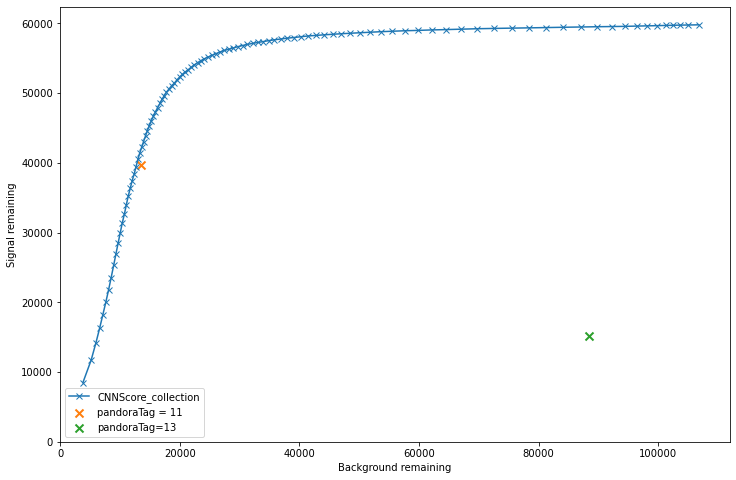

In [17]:
fig = plt.figure(figsize=(12,8))
axis = fig.add_subplot()
rocCurve(
    cnn_score,
    pdg_vals,
    particle = 22, labels="CNNScore_collection", cut_high=True, ax = axis
)

axis.scatter(
    ak.num(pandora_tag[np.logical_and(pandora_tag == 11, pdg_vals != 22)], axis=0),
    ak.num(pandora_tag[np.logical_and(pandora_tag == 11, pdg_vals == 22)], axis=0),
    marker='x', label='pandoraTag = 11', lw=2, s=64, c='C1'
)
axis.scatter(
    ak.num(pandora_tag[np.logical_and(pandora_tag == 13, pdg_vals != 22)], axis=0),
    ak.num(pandora_tag[np.logical_and(pandora_tag == 13, pdg_vals == 22)], axis=0),
    marker='x', label='pandoraTag=13', lw=2, s=64, c='C2'
)
axis.legend()
axis.set_xlim(0)
axis.set_ylim(0)

plt.show()

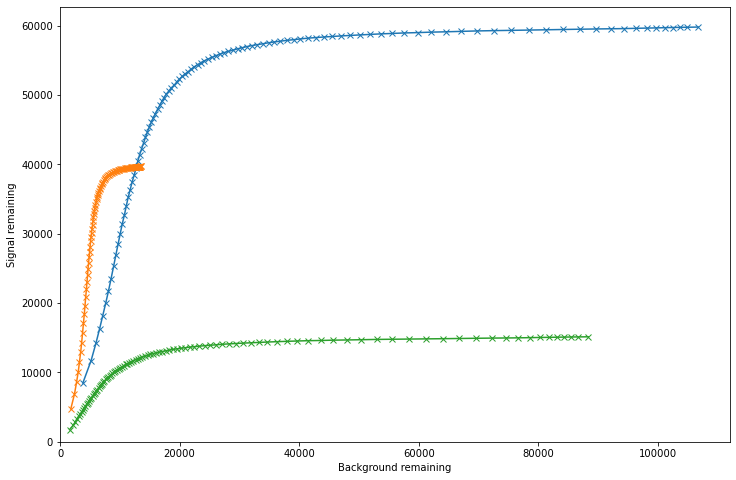

In [32]:
rocCurve(
    [cnn_score, cnn_score[pandora_tag == 11], cnn_score[pandora_tag == 13]],
    [pdg_vals, pdg_vals[pandora_tag == 11], pdg_vals[pandora_tag == 13]],
    labels=["CNNScore_collection", "CNNScore, tag=11", "CNNScore, tag=13"],
    particle = 22, cut_high=True
)


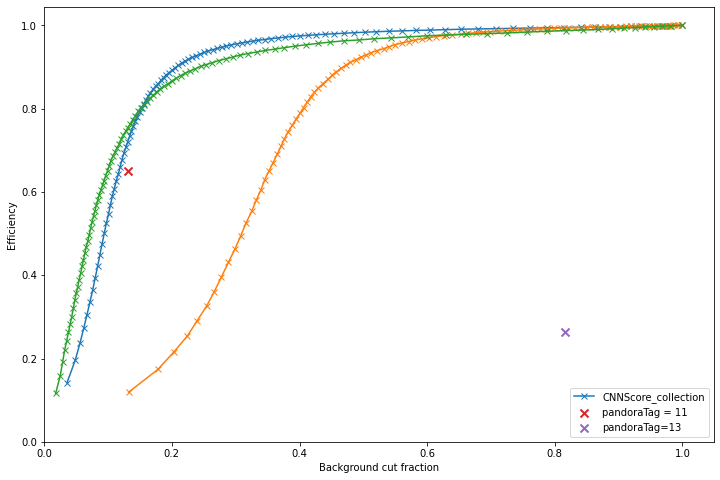

In [34]:
fig = plt.figure(figsize=(12,8))
axis = fig.add_subplot()
rocCurve(
    [cnn_score, cnn_score[pandora_tag == 11], cnn_score[pandora_tag == 13]],
    [pdg_vals, pdg_vals[pandora_tag == 11], pdg_vals[pandora_tag == 13]],
    labels=["CNNScore_collection", "CNNScore, tag=11", "CNNScore, tag=13"],
    particle = 22, cut_high=True, ax = axis, norm=True
)

axis.scatter(
    ak.num(pandora_tag[np.logical_and(pandora_tag == 11, pdg_vals != 22)], axis=0)/total_bkg,
    ak.num(pandora_tag[np.logical_and(pandora_tag == 11, pdg_vals == 22)], axis=0)/total_sig,
    marker='x', label='pandoraTag = 11', lw=2, s=64, c='C3'
)
axis.scatter(
    ak.num(pandora_tag[np.logical_and(pandora_tag == 13, pdg_vals != 22)], axis=0)/total_bkg,
    ak.num(pandora_tag[np.logical_and(pandora_tag == 13, pdg_vals == 22)], axis=0)/total_sig,
    marker='x', label='pandoraTag=13', lw=2, s=64, c='C4'
)
axis.legend()
axis.set_xlim(0)
axis.set_ylim(0)

plt.show()

Best cut found to be 1.280 with fpr: 22139.000, eff: 46072.000.
Best cut found to be 1.210 with fpr: 13013.000, eff: 40498.000.
Best cut found to be 1.010 with fpr: 22446.000, eff: 43448.000.
Best cut found to be 1.300 with fpr: 7230.000, eff: 33742.000.
Best cut found to be 1.310 with fpr: 12884.000, eff: 9679.000.


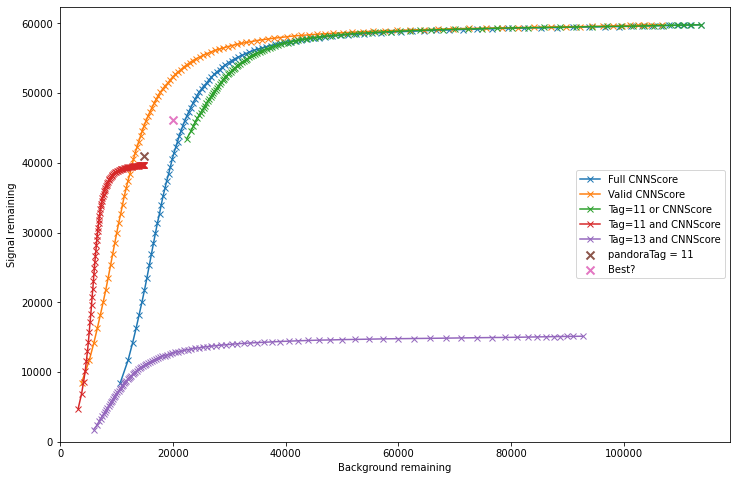

In [27]:
fig = plt.figure(figsize=(12,8))
axis = fig.add_subplot()
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Full CNNScore", cut_high=True, ax = axis, include_unknown=True
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Valid CNNScore", cut_high=True, ax = axis, include_unknown=False
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=11 or CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_or(x[m] < c, pandora_tag_all[m] == 11)
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=11 and CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_and(x[m] < c, pandora_tag_all[m] == 11)
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=13 and CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_and(x[m] < c, pandora_tag_all[m] == 13)
)
axis.scatter(
    sum(np.logical_and(pandora_tag_all == 11, pdg_vals_all != 22)),
    sum(np.logical_and(pandora_tag_all == 11, pdg_vals_all == 22)),
    marker='x', label='pandoraTag = 11', lw=2, s=64, c='C5'
)
axis.scatter(
    sum( np.logical_or(np.logical_and(np.logical_and(cnn_score_all < 1.3, pandora_tag_all == 11), pdg_vals_all != 22), np.logical_and(np.logical_and(cnn_score_all < 1.31, pandora_tag_all == 13), pdg_vals_all != 22)) ),
    sum( np.logical_or(np.logical_and(np.logical_and(cnn_score_all < 1.3, pandora_tag_all == 11), pdg_vals_all == 22), np.logical_and(np.logical_and(cnn_score_all < 1.31, pandora_tag_all == 13), pdg_vals_all == 22)) ),
    marker='x', label='Best?', lw=2, s=64, c='C6'
)

axis.legend()
axis.set_xlim(0)
axis.set_ylim(0)
# axis.set_xlim(10000)
# axis.set_ylim(10000)
# axis.set_xscale('log')
# axis.set_yscale('log')

plt.show()

Best cut found to be 1.410 with fpr: 0.240, eff: 0.836.
Best cut found to be 1.420 with fpr: 0.196, eff: 0.841.
Best cut found to be 1.270 with fpr: 0.262, eff: 0.836.
Best cut found to be 1.680 with fpr: 0.109, eff: 0.626.
Best cut found to be 1.580 with fpr: 0.205, eff: 0.211.


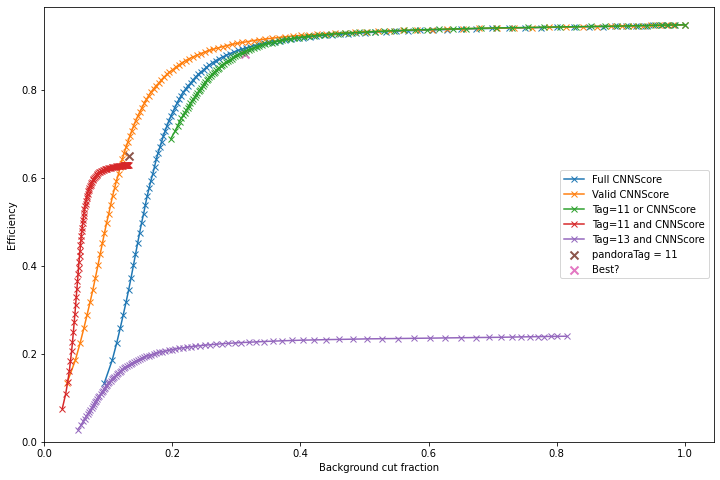

In [29]:
fig = plt.figure(figsize=(12,8))
axis = fig.add_subplot()
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Full CNNScore", cut_high=True, ax = axis, include_unknown=True, norm=True
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Valid CNNScore", cut_high=True, ax = axis, include_unknown=False, norm=True
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=11 or CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_or(x[m] < c, pandora_tag_all[m] == 11), norm=True
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=11 and CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_and(x[m] < c, pandora_tag_all[m] == 11), norm=True
)
rocCurve(
    cnn_score_all,
    pdg_vals_all,
    particle = 22, labels="Tag=13 and CNNScore", cut_high=True, ax = axis, include_unknown=True, cut_func = lambda x, m, c : np.logical_and(x[m] < c, pandora_tag_all[m] == 13), norm=True
)
axis.scatter(
    sum(np.logical_and(pandora_tag_all == 11, pdg_vals_all != 22))/total_bkg_all,
    sum(np.logical_and(pandora_tag_all == 11, pdg_vals_all == 22))/total_sig_all,
    marker='x', label='pandoraTag = 11', lw=2, s=64, c='C5'
)
axis.scatter(
    sum( np.logical_or(np.logical_and(np.logical_and(cnn_score_all < 1.68, pandora_tag_all == 11), pdg_vals_all != 22), np.logical_and(np.logical_and(cnn_score_all < 1.58, pandora_tag_all == 13), pdg_vals_all != 22)) ) /total_bkg_all,
    sum( np.logical_or(np.logical_and(np.logical_and(cnn_score_all < 1.68, pandora_tag_all == 11), pdg_vals_all == 22), np.logical_and(np.logical_and(cnn_score_all < 1.58, pandora_tag_all == 13), pdg_vals_all == 22)) ) /total_sig_all,
    marker='x', label='Best?', lw=2, s=64, c='C6'
)

axis.legend()
axis.set_xlim(0)
axis.set_ylim(0)
# axis.set_xlim(10000)
# axis.set_ylim(10000)
# axis.set_xscale('log')
# axis.set_yscale('log')

plt.show()

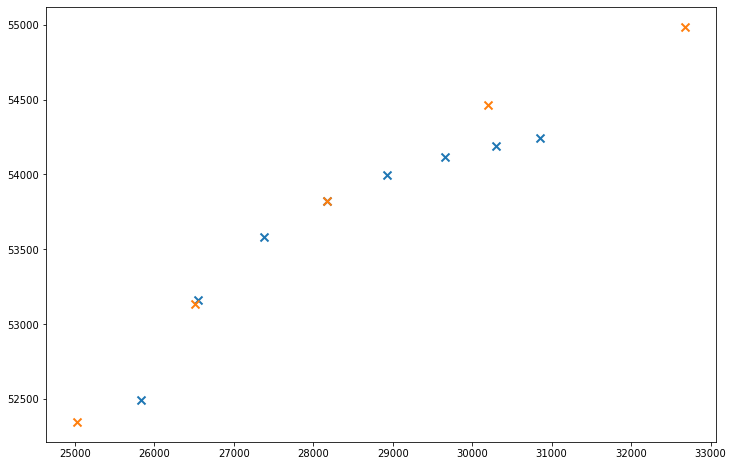

In [42]:
plt.figure(figsize=(12,8))
plt.scatter(
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<1.45), pdg_vals != 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<cut), pdg_vals != 22) )], axis=0) for cut in np.arange(1.45,1.8, 0.05)],
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<1.45), pdg_vals == 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<cut), pdg_vals == 22) )], axis=0) for cut in np.arange(1.45,1.8, 0.05)],
    marker='x', label='Cut on 11', lw=2, s=64, c='C0'
)
plt.scatter(
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<cut), pdg_vals != 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<1.6), pdg_vals != 22) )], axis=0) for cut in np.arange(1.35,1.6, 0.05)],
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<cut), pdg_vals == 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<1.6), pdg_vals == 22) )], axis=0) for cut in np.arange(1.35,1.6, 0.05)],
    marker='x', label='Cut on 13', lw=2, s=64, c='C1'
)
plt.scatter(
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<cut), pdg_vals != 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<1.6), pdg_vals != 22) )], axis=0) for cut in np.arange(1.35,1.6, 0.05)],
    [ak.num(pandora_tag[np.logical_or( np.logical_and(np.logical_and(pandora_tag == 13, cnn_score<cut), pdg_vals == 22), np.logical_and(np.logical_and(pandora_tag == 11, cnn_score<1.6), pdg_vals == 22) )], axis=0) for cut in np.arange(1.35,1.6, 0.05)],
    marker='x', label='Cut on 13', lw=2, s=64, c='C1'
)

plt.show()